# Individual Analysis for the M&ouml;ssbauer experiment

## Full analysis template

**This template walks through the analysis starting from the raw MCA spectrum files and associated velocity transducer measurements for each sample.  If you opt to use the LabVIEW data analysis window to obtain the spectrum peak positions and widths, you should use the *Mossbauer Results-Only Analysis* template.**

Use this template to carry out the analysis tasks for the experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will be making use of both the [Uncertainties](https://pythonhosted.org/uncertainties/) and [LMFit](https://lmfit.github.io/lmfit-py/) packages in this notebook.

In [134]:
import numpy as np  # import the numpy library functions.
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
import pandas as pd
import uncertainties.unumpy as unp
%matplotlib inline

### Tasks for this analysis

For each spectrum:

1. Use the peak-to-peak amplitude from the velocity transducer and to create a calibration function (a line).  You will need the function generator period and MCS dwell time.  The function should return a velocity in mm/s given a channel number.  Negative velocities should indicate negative energy shifts, and positive velocities should indicate positive energy shifts.

2. Apply your calibration function to the spectrum data sets for all spectra and plot them.

3. Use LMFit and follow the tutorial on fitting a complicated multi-peak function to a data set to fit the absorption peaks to Lorentzians plus a parabolic (2nd order polynomial) background. (Note: you may, if you wish, fit each peak at a time rather than fit the entire spectrum with one complicated curve.)

4. From the fits, obtain the peak center (with uncertainty) and peak width for each peak in each spectrum.  Record these results in tables, one table for each sample.  

You will use the peak positions in mm/s to complete the data analysis.


### Create the calibration function(s)

Think carefully about the motion of the source: where is it at the begining of the scan?  which direction is it moving? 

Think carefully about the dwell time and how long an MCS cycle takes.  (One cycle is a run through all channels.)  At which channel is the velocity zero?  Which channel would have the highest velocity forward and which would have the highest velocity in reverse.  Once you know this, you create a line that interpolates between these points. 

In [135]:
# Python "dictionary" to hold the peak-to-peak velocity transducer readings, in mV
Vpp = {'Fe':55.33, 'Nitroprusside':24.09, 'Fe2O3':74.15}

Vpp['Fe2O3']  # Should print the value for the labeled sample


74.15

#### Write the calibration function

Fill in the details below.


In [136]:
Conversion_const = unc.ufloat(0.295, 0.002)# The conversion constant for the transducer in mm/s/(mV)

def velocity_cal(chan, Vpp, conv=Conversion_const, dwell=5.0e-4, period=1.00):
    '''
    Velocity calibration function.  Converts channel number 'chan' to velocity with sign
    based on the measured peak-to-peak voltage from the velocity transducer 'Vpp' (in mV),
    the transducer conversion constant 'conv' (in (mm/s)/mV), the channel dwell time 
    'dwell' (in s), and the drive period 'period' (in s).  
    '''
    return(Vpp/2*conv - Vpp*conv/1000*(chan+0.5)) # slight correction to place velocity at middle of dwell time (1/2 channel)

# Test the function

a_channel = 250
print("Velocity at channel {} = {:4gP} mm/s".format(a_channel, velocity_cal(a_channel,Vpp=Vpp['Fe'])))


Velocity at channel 250 = 4.072±0.028 mm/s


### Work on the first datafile

Read in the first data file and then apply the calibration to convert channel numbers to velocity.  Plot the result.

**Note:**

The calibration, if done correctly, will flip the x-axis of the data set.  Assuming you are doing this on a column in a Pandas dataframe (the default when you read a csv file with `pd.read_csv()`) then the following will reorder the channel array so that the low index is on the left of the plot and the high index is on the right:

`Fe_velocity = velocity_cal(Fe['Chan'],Vpp['Fe']).sort_values()`

where `velocity_cal()` is the calibration function, `Fe['Chan']` is the data from the **Channel** column and `Vpp['Fe']` is the peak-to-peak voltage from the velocity transducer measurement.  The method attached to the end reorders the array from lowest to highest.

***However I recommend the following.***  Just add another column to the dataframe which holds the converted channels-to-velocity.  This makes it easier to deal with slices of the array.  In other words do this:

`Fe['velocity'] = velocity_cal(Fe['Chan'],Vpp['Fe'])`

Then you can reference the original channels when you need to, but pass the velocity to the fitting routines when you need to get results in mm/s.


#### Read in the data file

The raw data files are tab separated two-column files with a one-line header that does not matter for multichannel scaling files.  You need to skip the header and name the columns to create a dataframe.

Use the **Pandas** `read_csv()` function to read the raw data file from the Norland MCA as follows:

    Fe = pd.read_csv('enriched_Fe_data.txt',header=0,names=['Chan','Counts'],sep='\t')
    
The dataframe will be named `Fe`  with columns `Fe['Chan']` ad `Fe['Counts']`. 

In [137]:
#Read in the enriched_Fe data:
Fe = pd.read_csv('EnrichedFe.csv')
Fe

,Ch,Ct
0,0,2062
1,1,2154
2,2,2105
3,3,2109
4,4,2028
...,...,...
1019,1019,2190
1020,1020,2137
1021,1021,2152
1022,1022,2130


In [138]:
# Apply the calibration:
Fe['velocity'] = velocity_cal(Fe['Ch'],Vpp['Fe'])
Fe['velocity']

0        8.15+/-0.06
1        8.14+/-0.06
2        8.12+/-0.06
3        8.10+/-0.05
4        8.09+/-0.05
            ...     
1019    -8.48+/-0.06
1020    -8.50+/-0.06
1021    -8.51+/-0.06
1022    -8.53+/-0.06
1023    -8.54+/-0.06
Name: velocity, Length: 1024, dtype: object

Make a plot to check that it looks right.

<ErrorbarContainer object of 3 artists>

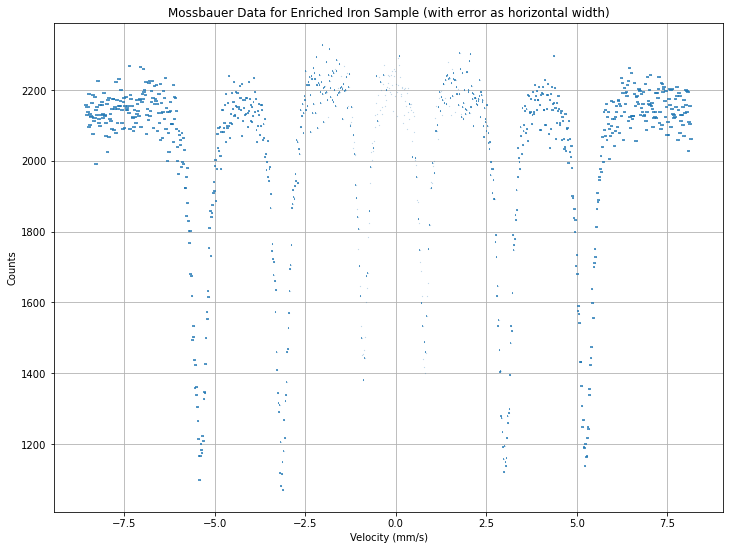

In [139]:
#conver the unc object to normal array
Fe_velocity = unp.nominal_values(Fe['velocity'])
Fe_unc = unp.std_devs(Fe['velocity'])
# Sanity plot
myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Enriched Iron Sample (with error as horizontal width)')
plt.errorbar(Fe_velocity, Fe['Ct'], xerr=Fe_unc, fmt='o', markersize=0.1)

Next, plot against the column index to be able to esitmate a slice.  Take the slice and plot it to check. (these plots do not need to have axis labels, or be particularly big.)

You will also want to plot against the velocity array in order to estimate the fitting parameter start values.

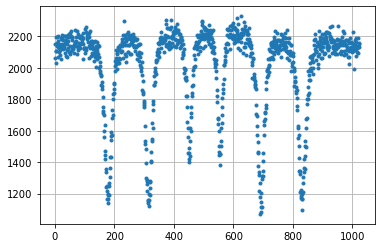

In [140]:
plt.grid()
plt.plot(Fe['Ct'],'.');

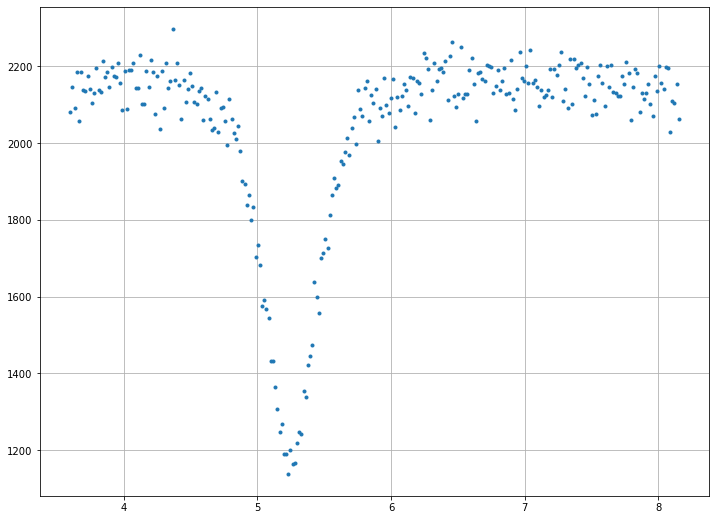

In [141]:
Index = list(range(0,280))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Fe_velocity[Index],Fe['Ct'][Index],'.');

### Fit the slice to the model

Now you should be reday to apply the procedure described in the **Composite Model Demo - Mossbauer** notebook.

Below is a reminder of the basic steps.

### Make the model

The model fit will consist of two Lorentzian peaks and a quadratic background.

The background fuction has the form
$$f(x;a,b,c) = ax^2 + bx + c\;.$$

The Lorentzian lineshape has the form
$$f(x;A,\mu,\sigma) = \frac{A}{\pi}\left[\frac{\sigma}{(x-\mu)^2 + \sigma^2}\right]\;.$$ 

Note that the height of the peak at the center ($x=\mu$) is equal to $\frac{A}{\pi\sigma}$ and that the full-width at half-maximum is $2\sigma$.

In [142]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, LorentzianModel

# create an instance of the model
# Note use of prefixes to keep parameters separate
model1 = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')  + LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_') + LorentzianModel(prefix='p5_') + LorentzianModel(prefix='p6_')

model = model1

params = model.make_params()

print('parameter names: {}'.format(model.param_names))

parameter names: ['a', 'b', 'c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma', 'p3_amplitude', 'p3_center', 'p3_sigma', 'p4_amplitude', 'p4_center', 'p4_sigma', 'p5_amplitude', 'p5_center', 'p5_sigma', 'p6_amplitude', 'p6_center', 'p6_sigma']


### Set the fit parameter starting points

In [143]:
params['p1_center'].set(value=5.25, vary=True)
params['p1_amplitude'].set(value=-4000.0*0.15*np.pi, vary=True)
params['p1_sigma'].set(value=0.21, vary=True)

params['p2_center'].set(value=3.02, vary=True)
params['p2_amplitude'].set(value=-4000.0*15*np.pi, vary=True)
params['p2_sigma'].set(value=0.2, vary=True)

params['p3_center'].set(value=0.79, vary=True)
params['p3_amplitude'].set(value=-3000.0*15*np.pi, vary=True)
params['p3_sigma'].set(value=0.2, vary=True)

params['p4_center'].set(value=-0.89, vary=True)
params['p4_amplitude'].set(value=-3000.0*15*np.pi, vary=True)
params['p4_sigma'].set(value=0.2, vary=True)

params['p5_center'].set(value=-3.1, vary=True)
params['p5_amplitude'].set(value=-4000.0*15*np.pi, vary=True)
params['p5_sigma'].set(value=0.2, vary=True)

params['p6_center'].set(value=-5.3, vary=True)
params['p6_amplitude'].set(value=-4000.0*15*np.pi, vary=True)
params['p6_sigma'].set(value=0.2, vary=True)

params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 10000.0, vary=True)

params.pretty_print(columns=['value','vary'])

Name             Value     Vary
a                    0    False
b                    0    False
c                1e+04     True
p1_amplitude     -1885     True
p1_center         5.25     True
p1_fwhm           0.42    False
p1_height        -2857    False
p1_sigma          0.21     True
p2_amplitude  -1.885e+05     True
p2_center         3.02     True
p2_fwhm            0.4    False
p2_height       -3e+05    False
p2_sigma           0.2     True
p3_amplitude  -1.414e+05     True
p3_center         0.79     True
p3_fwhm            0.4    False
p3_height     -2.25e+05    False
p3_sigma           0.2     True
p4_amplitude  -1.414e+05     True
p4_center        -0.89     True
p4_fwhm            0.4    False
p4_height     -2.25e+05    False
p4_sigma           0.2     True
p5_amplitude  -1.885e+05     True
p5_center         -3.1     True
p5_fwhm            0.4    False
p5_height       -3e+05    False
p5_sigma           0.2     True
p6_amplitude  -1.885e+05     True
p6_center         -5.3     T

Then fit.  The code below is an example.  Note the use of wieghts from Poisson statistics of counting and also the commands to resize the plot from the fitting routine.

[[Model]]
    ((((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 161
    # data points      = 1024
    # variables        = 19
    chi-square         = 1619.81677
    reduced chi-square = 1.61175798
    Akaike info crit   = 507.602827
    Bayesian info crit = 601.300792
    R-squared          = 0.99997893
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             2216.54132 +/- 2.95247701 (0.13%) (init = 10000)
    p1_amplitude: -732.882611 +/- 13.1189427 (1.79%) (init = -1884.956)
    p1_center:     5.24973442 +/- 0.00314288 (0.06%) (init = 5.25)
    p1_sigma:      0.22024624 +/- 0.00495079 (2.25%) (init = 0.21)
    p2_amplitude: -678.677951 +/- 11.9581806 (1.76%) (init = -188495.6)
    p2_center:  

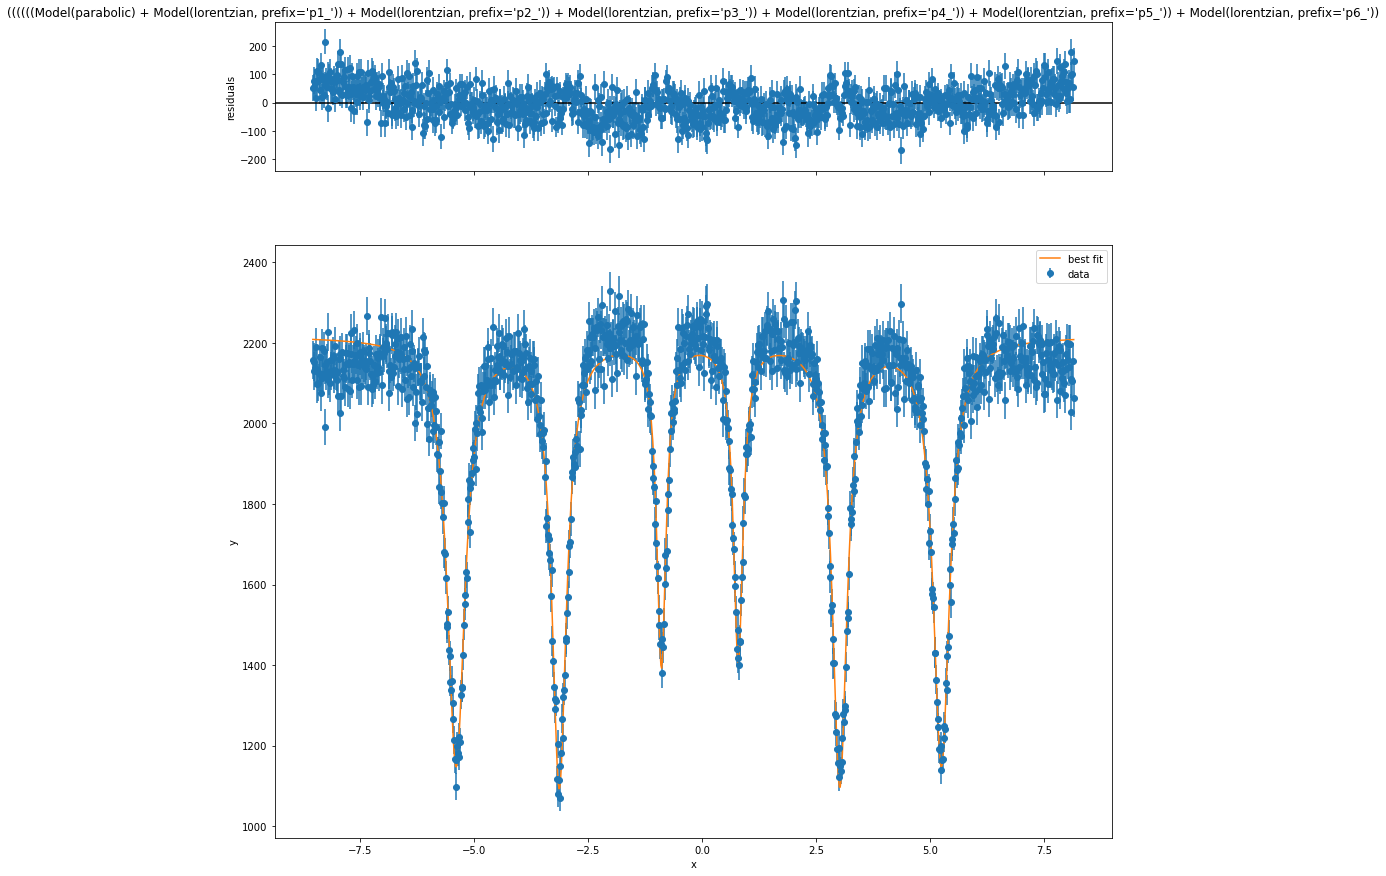

In [144]:
model_fit = model.fit(Fe['Ct'], params, x=Fe_velocity, weights=1/np.sqrt(Fe['Ct']))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);

### Save the peak centers

When you have obtained the best values, save the peak parameters.  I like to make a dataframe.  Here is one way to iterate over the parameters after they have been saved to extract the peak locations and uncertainties and make a table.

In [145]:
# Save the parameters from the best fit
Fe_params = model_fit.params

Fe_peaks = []
for parm in Fe_params:
    if parm.endswith('center'): 
        Fe_peaks.append(unc.ufloat(Fe_params[parm].value, Fe_params[parm].stderr))
        

In [146]:
Fe_peaks_df = pd.DataFrame()
Fe_peaks_df['Number'] = [1,2,3,4,5,6]
Fe_peaks_df['Location (mm/s)'] = Fe_peaks
Fe_peaks_df

,Number,Location (mm/s)
0,1,5.2497+/-0.0031
1,2,3.0198+/-0.0028
2,3,0.7914+/-0.0034
3,4,-0.8936+/-0.0033
4,5,-3.1359+/-0.0028
5,6,-5.3999+/-0.0033


### Repeat for Hematite:

<ErrorbarContainer object of 3 artists>

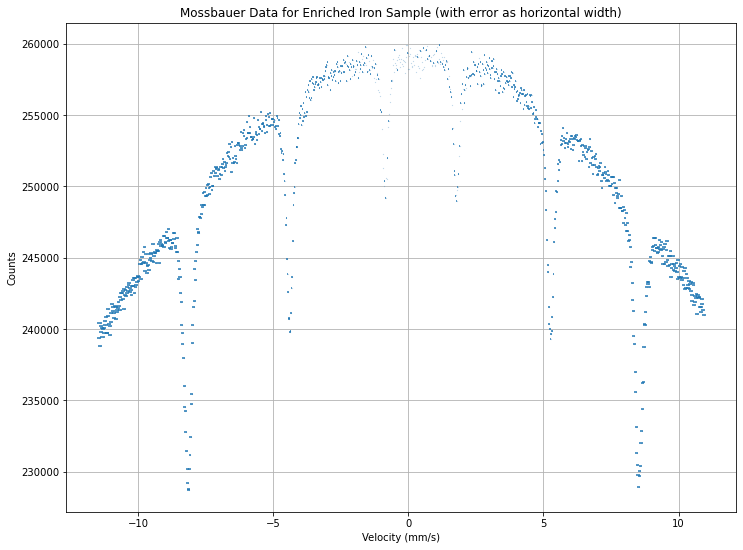

In [162]:
#Read in the enriched_Fe data:
Hem = pd.read_csv('Fe2O3.csv')

# Apply the calibration:
Hem['velocity'] = velocity_cal(Hem['Ch'],Vpp['Fe2O3'])

# convert the unc object to normal array
Hem_velocity = unp.nominal_values(Hem['velocity'])
Hem_unc = unp.std_devs(Hem['velocity'])

# Sanity plot
myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Enriched Iron Sample (with error as horizontal width)')
plt.errorbar(Hem_velocity, Hem['Ct'], xerr=Hem_unc, fmt='o', markersize=0.1)

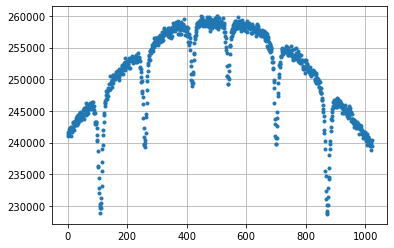

In [157]:
#simple plot:
plt.grid()
plt.plot(Hem['Ct'],'.');

[[Model]]
    ((((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1356
    # data points      = 1024
    # variables        = 19
    chi-square         = 38500.9838
    reduced chi-square = 38.3094366
    Akaike info crit   = 3752.01448
    Bayesian info crit = 3845.71245
    R-squared          = 0.99999919
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             268430.551 +/- 2044.01137 (0.76%) (init = 10000)
    p1_amplitude: -253857.801 +/- 32977.0621 (12.99%) (init = -9000)
    p1_center:     9.64662414 +/- 0.09885459 (1.02%) (init = 8.5)
    p1_sigma:      3.39616014 +/- 0.28266905 (8.32%) (init = 0.15)
    p2_amplitude: -7790.80389 +/- 779.836826 (10.01%) (init = -9000)
    p2_center:     5.2

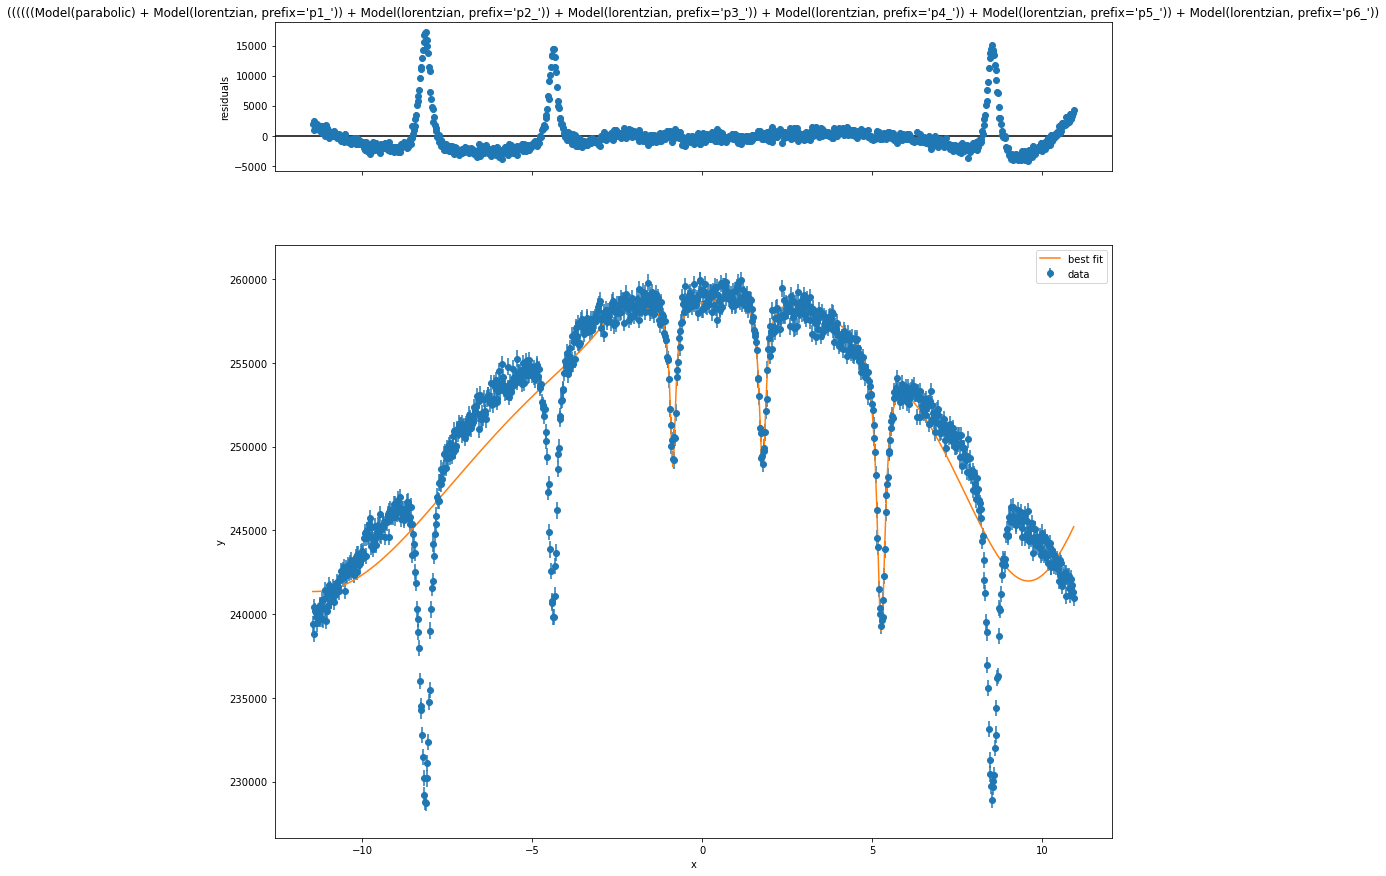

In [164]:


# create a model with the bkg and two peaks
model2 = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')  
# + LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_') + LorentzianModel(prefix='p5_') + LorentzianModel(prefix='p6_')

#initialize params
params = model2.make_params()

#observe and set the guess params
params['p1_center'].set(value=8.5, vary=True)
params['p1_amplitude'].set(value=-9000, vary=True)
params['p1_sigma'].set(value=0.15, vary=True)

params['p2_center'].set(value=5.05, vary=True)
params['p2_amplitude'].set(value=-9000, vary=True)
params['p2_sigma'].set(value=0.15, vary=True)

# params['p3_center'].set(value=2, vary=True)
# params['p3_amplitude'].set(value=-9000, vary=True)
# params['p3_sigma'].set(value=0.15, vary=True)

# params['p4_center'].set(value=-1, vary=True)
# params['p4_amplitude'].set(value=-9000, vary=True)
# params['p4_sigma'].set(value=0.15, vary=True)

# params['p5_center'].set(value=-4, vary=True)
# params['p5_amplitude'].set(value=-9000, vary=True)
# params['p5_sigma'].set(value=0.15, vary=True)

# params['p6_center'].set(value=-8, vary=True)
# params['p6_amplitude'].set(value=-9000, vary=True)
# params['p6_sigma'].set(value=0.15, vary=True)

params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 10000.0, vary=True)

#select a peak
# Index = list(range(0,200))

# fit the model for the peak
# model_fit = model2.fit(Hem['Ct'][Index], params, x=Hem_velocity[Index], weights=1/np.sqrt(Hem['Ct'][Index]))

model_fit = model2.fit(Hem['Ct'], params, x=Hem_velocity, weights=1/np.sqrt(Hem['Ct']))

# print the report
print(model_fit.fit_report(show_correl=False))

# plot the fit
myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);




## Repeat the above procedure for the other data files.

Remember: your goal here is a list of the best-fit peak locations in mm/s units for each data run.

## Calculate final results

Carry out the analysis below that is relevant to your sample types

### Enriched iron

1. Start with isomer shift $\delta$. This is just the average of all peak locations. The number would be relative to the source Co-57/Rh

2. Next calculate the magnetic field $B$ and excited-state moment $\mu_e$ from the enriched-foil data.  

For the field, we first need the transitions that start from different ground states and end at the same excited states.  There are two pairs of these, one pair ends at -1/2: peaks 2 & 4, and the other ends at +1/2, peaks 1 and 3. The differences between these will give $\mu_gB$.  From this get $B$ with $\mu_g = +0.09062\mu_n$ where $\mu_n = 3.1525\times10^{-8}$ eV/T 

You will need to convert to energy with Doppler formula
$$\frac{\Delta E}{E} = \frac{v}{c}$$
where $E = 14.412497$ keV.

To get the excited state moment, you will need the excited state splitting. These pairs that start at the same ground state but end at different excited states: peaks 0-1, 1-2, 3-4, and 4-5.

3. From this calculate the excited state moment $\mu_e$, and compare to $-0.1549\mu_n$. 

4. Repeat the above for any other natural iron samples you may have. (Don't forget to apply the correct calibration constant for each one.)

### Sodium nitroprusside

Need isomer shift relative to Fe foil and quadrupole split, both in mm/s units.

Compare results to literature values of $-0.257$ mm/s for the isomer shift, relative to Fe and $1.7048$ mm/s for the quadrupole splitting.  

### Hematite (Rust)

Analysis proceeds in same manner as for enriched Fe foil. Find $\delta$, $B$, $\mu_e$. 

#### Then find quadrupole splitting

From Figure 2 in Kistner & Sunyar (PRL Vol. 4, p.412, 1960) peaks 0-1 are closer together than 1-2 by $2\varepsilon$ and peaks 4-5 are farther apart than peaks 3-4.  To find $\varepsilon$ we note that (4-5)-(0-1) should be equal to $4\varepsilon$.

Compare to following results in Kistner & Sunyar:
* G.S Splitting = $6.11\pm0.05$ mm/s
* E.S. splitting = $3.45\pm0.03$ mm/s
* Isomer shift relative to Fe = $0.47\pm0.03$ mm/s
* Quadrupole splitting $\varepsilon = 0.12\pm0.03$ mm/s